In [36]:
# First, we need to load all necessary R packages using the library function

install.packages("kknn")
library(kknn)
library(tidyverse)
library(tidymodels)
library(repr)
library(dplyr)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘plotrix’


The following object is masked from ‘package:scales’:

    rescale




In [2]:
# Then, we need to read the data from a URL using appropriate read_* and assign it to a variable
# The dataset was downloaded from: "https://www.kaggle.com/datasets/armanakbari/connectionist-bench-sonar-mines-vs-rocks"

sonar_url <- "https://raw.githubusercontent.com/DannyPirouz/DSCI_100_Project/main/sonar.all-data.csv"
sonar_data <- read_csv(sonar_url)

Rows: 208 Columns: 61
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Label
dbl (60): Freq_1, Freq_2, Freq_3, Freq_4, Freq_5, Freq_6, Freq_7, Freq_8, Fr...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# Check to see if we have missing data

sum(is.na(sonar_data))

[1] 0

In [4]:
# Next, we need to convert the column "Label" to a factor type and change the name of the labels to improve readability

sonar_data <- sonar_data |>
              mutate(Label = as.factor(Label)) |>
              mutate(Label = fct_recode(Label, "Rock" = "R", "Mine" = "M"))
head(sonar_data, 5)
# Our data is now wrangled and clean

Freq_1 Freq_2 Freq_3 Freq_4 Freq_5 Freq_6 Freq_7 Freq_8 Freq_9 Freq_10 ⋯
1 0.0200 0.0371 0.0428 0.0207 0.0954 0.0986 0.1539 0.1601 0.3109 0.2111  ⋯
2 0.0453 0.0523 0.0843 0.0689 0.1183 0.2583 0.2156 0.3481 0.3337 0.2872  ⋯
3 0.0262 0.0582 0.1099 0.1083 0.0974 0.2280 0.2431 0.3771 0.5598 0.6194  ⋯
4 0.0100 0.0171 0.0623 0.0205 0.0205 0.0368 0.1098 0.1276 0.0598 0.1264  ⋯
5 0.0762 0.0666 0.0481 0.0394 0.0590 0.0649 0.1209 0.2467 0.3564 0.4459  ⋯
  Freq_52 Freq_53 Freq_54 Freq_55 Freq_56 Freq_57 Freq_58 Freq_59 Freq_60 Label
1 0.0027  0.0065  0.0159  0.0072  0.0167  0.0180  0.0084  0.0090  0.0032  Rock 
2 0.0084  0.0089  0.0048  0.0094  0.0191  0.0140  0.0049  0.0052  0.0044  Rock 
3 0.0232  0.0166  0.0095  0.0180  0.0244  0.0316  0.0164  0.0095  0.0078  Rock 
4 0.0121  0.0036  0.0150  0.0085  0.0073  0.0050  0.0044  0.0040  0.0117  Rock 
5 0.0031  0.0054  0.0105  0.0110  0.0015  0.0072  0.0048  0.0107  0.0094  Rock

In [5]:
# Now, we want to see how many "Rocks" and "Mines" we have in our entire data set

count_table <- sonar_data |> 
               group_by(Label) |>
               summarize(Count = n()) |>
               mutate(Percentage = 100*Count/nrow(sonar_data))
count_table
# It is good that the percentages are close to 50%

Label Count Percentage
1 Mine  111   53.36538  
2 Rock   97   46.63462

In [6]:
# We need to split the data into the training portion and the testing portion 
# The initial_split function will create randomness for us 
set.seed(1)

sonar_split <- initial_split(sonar_data, prop = 0.75, strata = Label)
sonar_train <- training(sonar_split)
sonar_test <- testing(sonar_split)

head(sonar_train, 5)

Freq_1 Freq_2 Freq_3 Freq_4 Freq_5 Freq_6 Freq_7 Freq_8 Freq_9 Freq_10 ⋯
1 0.0491 0.0279 0.0592 0.1270 0.1772 0.1908 0.2217 0.0768 0.1246 0.2028  ⋯
2 0.1313 0.2339 0.3059 0.4264 0.4010 0.1791 0.1853 0.0055 0.1929 0.2231  ⋯
3 0.0587 0.1210 0.1268 0.1498 0.1436 0.0561 0.0832 0.0672 0.1372 0.2352  ⋯
4 0.0162 0.0253 0.0262 0.0386 0.0645 0.0472 0.1056 0.1388 0.0598 0.1334  ⋯
5 0.0428 0.0555 0.0708 0.0618 0.1215 0.1524 0.1543 0.0391 0.0610 0.0113  ⋯
  Freq_52 Freq_53 Freq_54 Freq_55 Freq_56 Freq_57 Freq_58 Freq_59 Freq_60 Label
1 0.0081  0.0129  0.0161  0.0063  0.0119  0.0194  0.0140  0.0332  0.0439  Mine 
2 0.0362  0.0210  0.0154  0.0180  0.0013  0.0106  0.0127  0.0178  0.0231  Mine 
3 0.0331  0.0111  0.0088  0.0158  0.0122  0.0038  0.0101  0.0228  0.0124  Mine 
4 0.0071  0.0082  0.0232  0.0198  0.0074  0.0035  0.0100  0.0048  0.0019  Mine 
5 0.0142  0.0179  0.0079  0.0060  0.0131  0.0089  0.0084  0.0113  0.0049  Mine

In [7]:
# We have created a table to see how many "Rocks" and "Mines" we have in our training data

label_proportions_table <- sonar_train |>
                           group_by(Label) |> 
                           summarize(Count = n()) |>
                           mutate(Percentage = 100*Count/nrow(sonar_train))

label_proportions_table

# We notice that our "Label" proportions were preserved when we split the data 

Label Count Percentage
1 Mine  83    53.54839  
2 Rock  72    46.45161

In [8]:
# Finding the mean of every frequency

freq_means_per_column <- sonar_train |>
              select(Freq_1:Freq_60) |>
              map_df(mean)

freq_means_per_column <- pivot_longer(freq_means_per_column, cols = Freq_1:Freq_60, names_to = "Frequency_Number", values_to = "Mean_Frequency_Value")
head(freq_means_per_column, 5)

Frequency_Number Mean_Frequency_Value
1 Freq_1           0.02929355          
2 Freq_2           0.03812516          
3 Freq_3           0.04391935          
4 Freq_4           0.05357097          
5 Freq_5           0.07398516

In [9]:
# Finding the mean of every frequency grouped by "Label"

freq_means_grouped_by_label <- sonar_train |>
                               group_by(Label) |>
                               summarize(across(Freq_1:Freq_60, ~ mean(.x, na.rm = TRUE)))
 
freq_means_grouped_by_label <- pivot_longer(freq_means_grouped_by_label, cols = Freq_1:Freq_60, names_to = "Frequency Number", values_to = "Mean Frequency Value")
head(freq_means_grouped_by_label, 5)
tail(freq_means_grouped_by_label, 5)

Label Frequency Number Mean Frequency Value
1 Mine  Freq_1           0.03610361          
2 Mine  Freq_2           0.04571928          
3 Mine  Freq_3           0.05000120          
4 Mine  Freq_4           0.06252048          
5 Mine  Freq_5           0.08449759

Label Frequency Number Mean Frequency Value
1 Rock  Freq_56          0.007316667         
2 Rock  Freq_57          0.007904167         
3 Rock  Freq_58          0.006444444         
4 Rock  Freq_59          0.006895833         
5 Rock  Freq_60          0.006086111

In [10]:
# Finding the maximum of every frequency

freq_max_per_column <- sonar_train |>
            select(Freq_1:Freq_60) |>
            map_df(max)

freq_max_per_column <- pivot_longer(freq_max_per_column, cols = Freq_1:Freq_60, names_to = "Frequency Number", values_to = " Maximum Frequency Value")
head(freq_max_per_column, 5)

Frequency Number  Maximum Frequency Value
1 Freq_1           0.1371                  
2 Freq_2           0.2339                  
3 Freq_3           0.3059                  
4 Freq_4           0.4264                  
5 Freq_5           0.4010

In [11]:
# Finding the minimum of every frequency

freq_min_per_column <- sonar_train |>
            select(Freq_1:Freq_60) |>
            map_df(min)

freq_min_per_column <- pivot_longer(freq_min_per_column, cols = Freq_1:Freq_60, names_to = "Frequency Number", values_to = " Minimum Frequency Value")
head(freq_min_per_column, 5)

Frequency Number  Minimum Frequency Value
1 Freq_1           0.0015                  
2 Freq_2           0.0006                  
3 Freq_3           0.0015                  
4 Freq_4           0.0058                  
5 Freq_5           0.0067

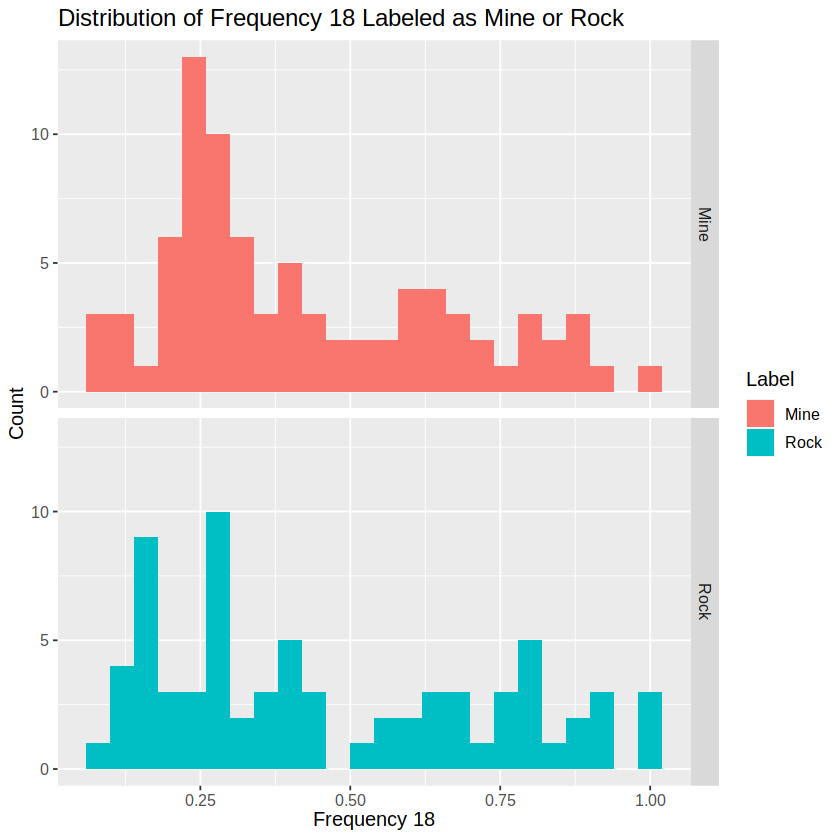

In [12]:
# Plotting a histogram of various frequencies to see what their distributions look like

# The data never mentioned what the units for the energy represented by each frequency so we were not able to include those units

hist_18 <- ggplot(sonar_train, aes(x = Freq_18, fill = Label)) + 
          geom_histogram(position = "identity", binwidth = 0.04) + 
          labs(x = "Frequency 18", y = "Count", fill = "Label") +
          ggtitle("Distribution of Frequency 18 Labeled as Mine or Rock") +
          theme(text = element_text(size = 12)) +
          facet_grid(rows = vars(Label))
hist_18

# These two histograms have very similar distributions as they both have their modes at around 0.025. 
# Since the distributions are very similar, it is very unlikely that this frequency would be a driving force.

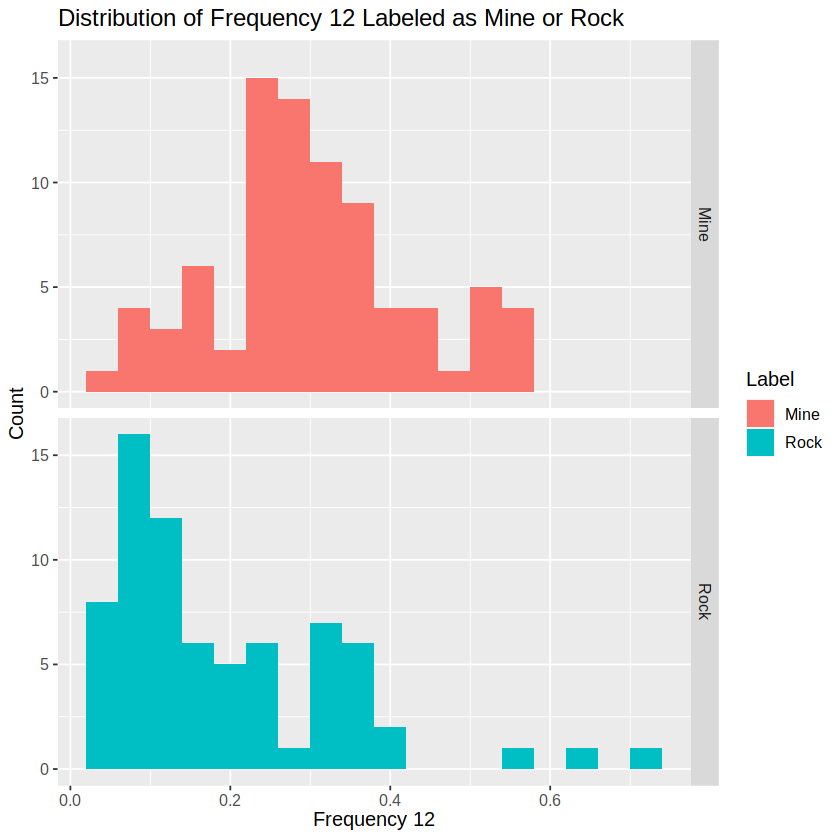

In [13]:
hist_12 <- ggplot(sonar_train, aes(x = Freq_12, fill = Label)) + 
          geom_histogram(position = "identity", binwidth = 0.04) + 
          labs(x = "Frequency 12", y = "Count", fill = "Label") +
          ggtitle("Distribution of Frequency 12 Labeled as Mine or Rock") +
          theme(text = element_text(size = 12)) +
          facet_grid(rows = vars(Label))
hist_12

# These two histograms have different distributions. 
# The mine distribution resembles a bell-shape with the average around 0.3.
# The rock distribution is very right-skewed with a mode at around 0.1.
# Since the distributions are different, this suggests that this frequency could be a driving factor.

In [14]:
# Now we are going to create scatter plots with various frequencies to see if we can identify any groupings or patterns
# First, we have to scale our data for the scatter plot
# Then, we can create the scatter plot

set.seed(3)

sonar_train_recipe <- recipe(Label ~ ., data = sonar_train) |>
                      step_scale(all_predictors()) |>
                      step_center(all_predictors()) |>
                      prep()

scaled_sonar_train <- bake(sonar_train_recipe, sonar_train)

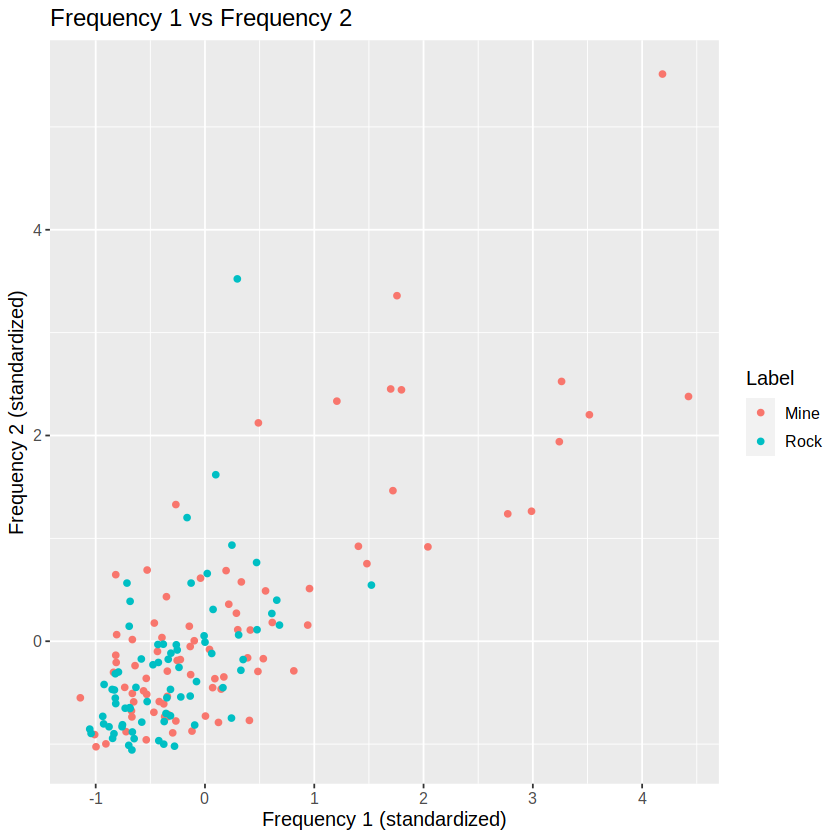

In [15]:
scatterplot_1_and_2 <- ggplot(scaled_sonar_train, aes(x = Freq_1, y = Freq_2, colour = Label)) + 
                       geom_point() +
                       labs(x = "Frequency 1 (standardized)", y = "Frequency 2 (standardized)") +
                       ggtitle("Frequency 1 vs Frequency 2") +
                       theme(text = element_text(size = 12))
                       
scatterplot_1_and_2

# The plot looks to have a positive relationship with the mines dominating the higher frequency values. 
# As Frequency 1 increases, Frequency 2 also increases.
# The strength doesn't seem to be very strong as the data points are fairly spread.

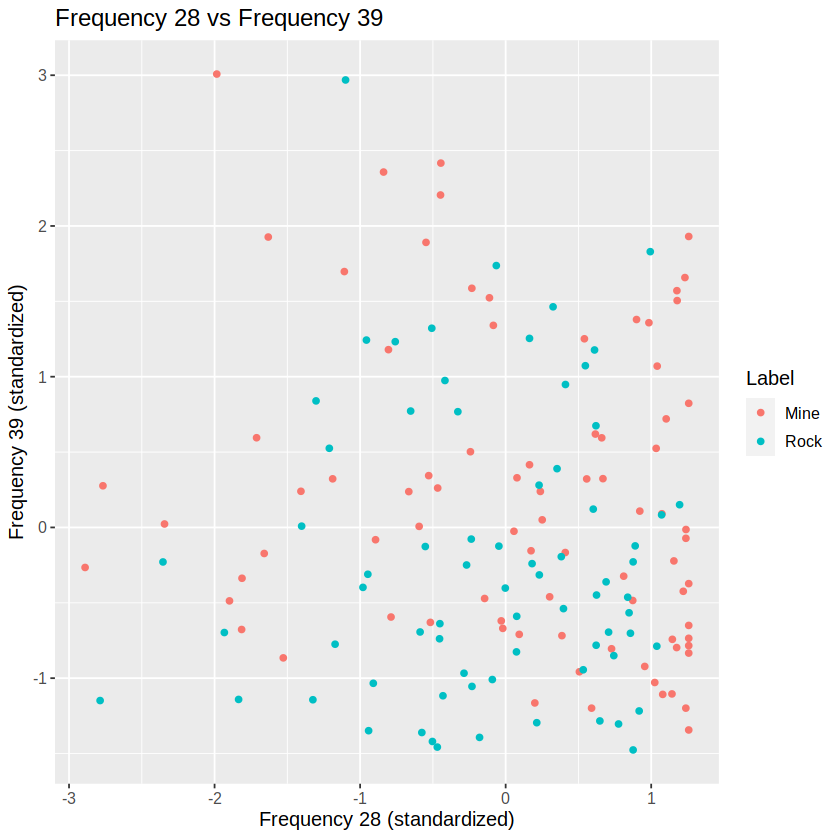

In [16]:
scatterplot_28_and_39 <- ggplot(scaled_sonar_train, aes(x = Freq_28, y = Freq_39, colour = Label)) + 
                         geom_point() +
                         labs(x = "Frequency 28 (standardized)", y = "Frequency 39 (standardized)") +
                         ggtitle("Frequency 28 vs Frequency 39") +
                         theme(text = element_text(size = 12))
                       
scatterplot_28_and_39

# There is no relationship between these two frequencies. The data points are all over the place.
# This suggests that these two frequencies have nothing to do with each other. 

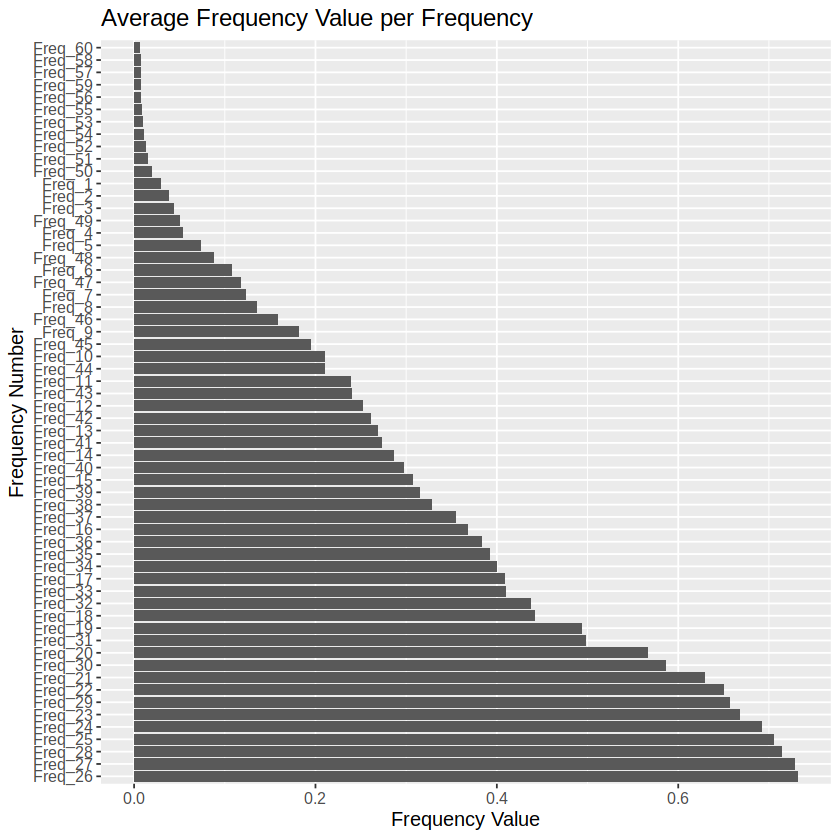

In [17]:
# This is a bar plot of the average frequency value of every frequency


sonar_bar_mean <- ggplot(freq_means_per_column, aes(x = Mean_Frequency_Value, y = fct_reorder(Frequency_Number, Mean_Frequency_Value, .desc = TRUE))) + 
                  geom_bar(stat = "identity") +
                  labs(x = "Frequency Value", y = "Frequency Number") +
                  ggtitle("Average Frequency Value per Frequency") +
                  theme(text = element_text(size = 12))
sonar_bar_mean

# We see that frequency 60 has the lowest average frequency close to 0 and frequency 26 has the highest just above 0.7.
# Not many of the frequencies have similar frequency averages. 

neighbors .metric  .estimator mean      n std_err    .config              
1 1         accuracy binary     0.8517070 5 0.02819277 Preprocessor1_Model01
2 2         accuracy binary     0.8517070 5 0.02819277 Preprocessor1_Model02
3 3         accuracy binary     0.8635618 5 0.02542111 Preprocessor1_Model03
4 4         accuracy binary     0.8635618 5 0.02542111 Preprocessor1_Model04
5 5         accuracy binary     0.8194086 5 0.01928231 Preprocessor1_Model05

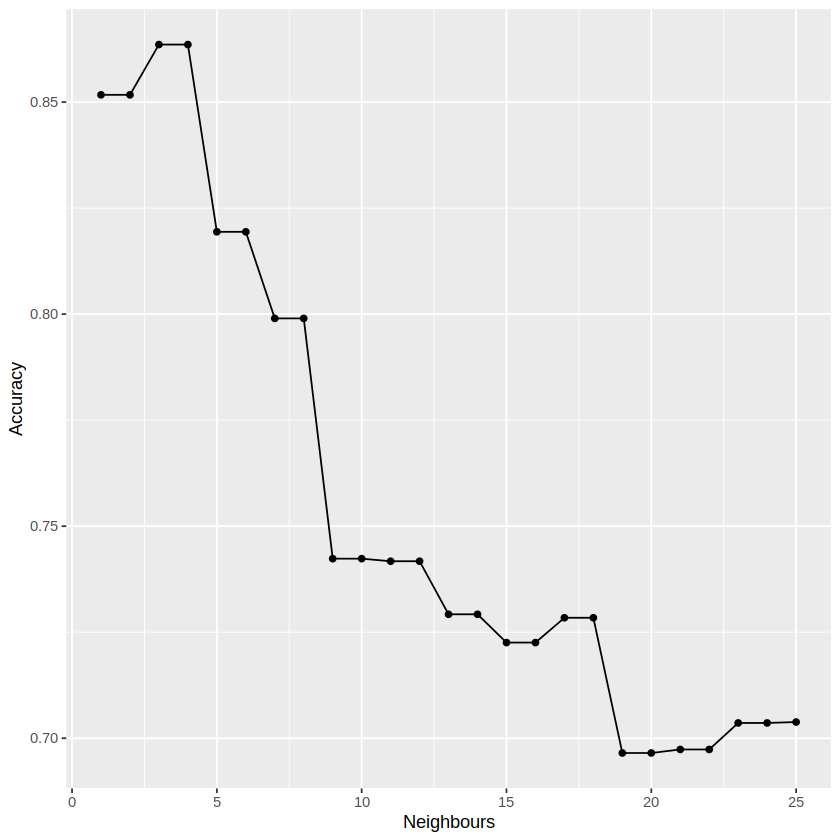

In [18]:
# We alreadly split our data into our training set and our testing set
# We also have already made our recipe

set.seed(3)

# Now we need to make a model specification with tune() as the neighbours 
# to find the best number of neighbours

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

# Here we want to specify how many coss-validations we want

number_vfold <- vfold_cv(sonar_train, v = 5, strata = Label)

# This is the range of k values we are testing

k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))

# Now we are putting it all in a workflow

knn_fit <- workflow() |>
add_recipe(sonar_train_recipe) |>
add_model(knn_spec) |>
tune_grid(resamples = number_vfold, grid = k_vals) |>
collect_metrics()

accuracy <- knn_fit |>
filter(.metric == "accuracy")

# We make a plot to find the k with the highest accuracy

cross_val_plot <- ggplot(accuracy, aes(x = neighbors, y = mean)) + geom_point() + geom_line () + labs(x = "Neighbours", y = "Accuracy")

cross_val_plot

# We see that k is highest at 3 or 4 but we will use 3 as we have 2 labels
# which means we won't have even splits now.

head(accuracy, 5)

# The highest accuracy is 86.35618% to be exact

In [19]:
set.seed(4)

# Now that we found k = 3, we create a new workflow

new_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
set_engine("kknn") |>
set_mode("classification")

new_knn_fit <- workflow() |>
add_recipe(sonar_train_recipe) |>
add_model(new_knn_spec) |>
fit(data = sonar_train)

# Now we can test our testing set

sonar_test_predictions <- predict(new_knn_fit, sonar_test) |>
bind_cols(sonar_test)

head(sonar_test_predictions, 5)
tail(sonar_test_predictions, 5)

.pred_class Freq_1 Freq_2 Freq_3 Freq_4 Freq_5 Freq_6 Freq_7 Freq_8 Freq_9 ⋯
1 Rock        0.0100 0.0171 0.0623 0.0205 0.0205 0.0368 0.1098 0.1276 0.0598 ⋯
2 Mine        0.0762 0.0666 0.0481 0.0394 0.0590 0.0649 0.1209 0.2467 0.3564 ⋯
3 Rock        0.0286 0.0453 0.0277 0.0174 0.0384 0.0990 0.1201 0.1833 0.2105 ⋯
4 Mine        0.0519 0.0548 0.0842 0.0319 0.1158 0.0922 0.1027 0.0613 0.1465 ⋯
5 Mine        0.0223 0.0375 0.0484 0.0475 0.0647 0.0591 0.0753 0.0098 0.0684 ⋯
  Freq_52 Freq_53 Freq_54 Freq_55 Freq_56 Freq_57 Freq_58 Freq_59 Freq_60 Label
1 0.0121  0.0036  0.0150  0.0085  0.0073  0.0050  0.0044  0.0040  0.0117  Rock 
2 0.0031  0.0054  0.0105  0.0110  0.0015  0.0072  0.0048  0.0107  0.0094  Rock 
3 0.0045  0.0014  0.0038  0.0013  0.0089  0.0057  0.0027  0.0051  0.0062  Rock 
4 0.0081  0.0120  0.0045  0.0121  0.0097  0.0085  0.0047  0.0048  0.0053  Rock 
5 0.0145  0.0128  0.0145  0.0058  0.0049  0.0065  0.0093  0.0059  0.0022  Rock

.pred_class Freq_1 Freq_2 Freq_3 Freq_4 Freq_5 Freq_6 Freq_7 Freq_8 Freq_9 ⋯
1 Mine        0.0368 0.0279 0.0103 0.0566 0.0759 0.0679 0.0970 0.1473 0.2164 ⋯
2 Mine        0.0158 0.0239 0.0150 0.0494 0.0988 0.1425 0.1463 0.1219 0.1697 ⋯
3 Mine        0.0056 0.0267 0.0221 0.0561 0.0936 0.1146 0.0706 0.0996 0.1673 ⋯
4 Mine        0.0116 0.0744 0.0367 0.0225 0.0076 0.0545 0.1110 0.1069 0.1708 ⋯
5 Mine        0.0272 0.0378 0.0488 0.0848 0.1127 0.1103 0.1349 0.2337 0.3113 ⋯
  Freq_52 Freq_53 Freq_54 Freq_55 Freq_56 Freq_57 Freq_58 Freq_59 Freq_60 Label
1 0.0105  0.0024  0.0018  0.0057  0.0092  0.0009  0.0086  0.0110  0.0052  Mine 
2 0.0121  0.0108  0.0057  0.0028  0.0079  0.0034  0.0046  0.0022  0.0021  Mine 
3 0.0072  0.0055  0.0074  0.0068  0.0084  0.0037  0.0024  0.0034  0.0007  Mine 
4 0.0141  0.0103  0.0100  0.0034  0.0026  0.0037  0.0044  0.0057  0.0035  Mine 
5 0.0091  0.0045  0.0043  0.0043  0.0098  0.0054  0.0051  0.0065  0.0103  Mine

In [20]:
set.seed(4)

# We get the confusion matrix for our testing set

sonar_metrics <- sonar_test_predictions |>
metrics(truth = Label, estimate = .pred_class) |>
filter(.metric == "accuracy")
sonar_metrics

sonar_conf_mat <- sonar_test_predictions |>
conf_mat(truth = Label, estimate = .pred_class)

sonar_conf_mat

# We see we have an accuracy of ~85% and that rocks are more likely 
# to be predicted mines than mines are predicted to be rocks.

.metric  .estimator .estimate
1 accuracy binary     0.8490566

          Truth
Prediction Mine Rock
      Mine   27    7
      Rock    1   18

In [21]:
set.seed(4)

# We are finally able to test our unknown label to determine what it is

unknown_label <- tibble(
Freq_1=0.029293548, Freq_2=0.038125161, Freq_3=0.043919355, Freq_4=0.053570968, Freq_5=0.073985161,
Freq_6=0.107596129, Freq_7=0.123939355, Freq_8=0.135519355, Freq_9=0.182131613, Freq_10=0.210321290,
Freq_11=0.239072258, Freq_12=0.252205161, Freq_13=0.269441935, Freq_14=0.287030968, Freq_15=0.307488387,
Freq_16=0.368141935, Freq_17=0.409109677, Freq_18=0.442067097, Freq_19=0.493798710, Freq_20=0.567036774,
Freq_21=0.629974839, Freq_22=0.650916774, Freq_23=0.668149032, Freq_24=0.692389677, Freq_25=0.706011613,
Freq_26=0.731724516, Freq_27=0.728425806, Freq_28=0.714849677, Freq_29=0.656634839, Freq_30=0.586917419,
Freq_31=0.498092903, Freq_32=0.438041290, Freq_33=0.410323226, Freq_34=0.399729032, Freq_35=0.392028387,
Freq_36=0.383221290, Freq_37=0.355252903, Freq_38=0.328312258, Freq_39=0.315471613, Freq_40=0.297972903,
Freq_41=0.273301290, Freq_42=0.261722581, Freq_43=0.240483871, Freq_44=0.210916774, Freq_45=0.194581935,
Freq_46=0.158237419, Freq_47=0.118338065, Freq_48=0.088425806, Freq_49=0.050437419, Freq_50=0.020080645,
Freq_51=0.015726452, Freq_52=0.013165161, Freq_53=0.010220645, Freq_54=0.010878065, Freq_55=0.008923871,
Freq_56=0.007916774, Freq_57=0.007650323, Freq_58=0.007411613, Freq_59=0.007715484, Freq_60=0.006610968)

predict(new_knn_fit, unknown_label)

# Our classifier predicted our unknown label as a Mine

.pred_class
1 Mine

In [87]:
set.seed(5)

# To create our visualizations, we need to add the new label to our dataframe

new_row <- data.frame(
Freq_1=0.029293548, Freq_2=0.038125161, Freq_3=0.043919355, Freq_4=0.053570968, Freq_5=0.073985161,
Freq_6=0.107596129, Freq_7=0.123939355, Freq_8=0.135519355, Freq_9=0.182131613, Freq_10=0.210321290,
Freq_11=0.239072258, Freq_12=0.252205161, Freq_13=0.269441935, Freq_14=0.287030968, Freq_15=0.307488387,
Freq_16=0.368141935, Freq_17=0.409109677, Freq_18=0.442067097, Freq_19=0.493798710, Freq_20=0.567036774,
Freq_21=0.629974839, Freq_22=0.650916774, Freq_23=0.668149032, Freq_24=0.692389677, Freq_25=0.706011613,
Freq_26=0.731724516, Freq_27=0.728425806, Freq_28=0.714849677, Freq_29=0.656634839, Freq_30=0.586917419,
Freq_31=0.498092903, Freq_32=0.438041290, Freq_33=0.410323226, Freq_34=0.399729032, Freq_35=0.392028387,
Freq_36=0.383221290, Freq_37=0.355252903, Freq_38=0.328312258, Freq_39=0.315471613, Freq_40=0.297972903,
Freq_41=0.273301290, Freq_42=0.261722581, Freq_43=0.240483871, Freq_44=0.210916774, Freq_45=0.194581935,
Freq_46=0.158237419, Freq_47=0.118338065, Freq_48=0.088425806, Freq_49=0.050437419, Freq_50=0.020080645,
Freq_51=0.015726452, Freq_52=0.013165161, Freq_53=0.010220645, Freq_54=0.010878065, Freq_55=0.008923871,
Freq_56=0.007916774, Freq_57=0.007650323, Freq_58=0.007411613, Freq_59=0.007715484, Freq_60=0.006610968, Label="Mine")

new_sonar <- rbind(sonar_data, new_row)

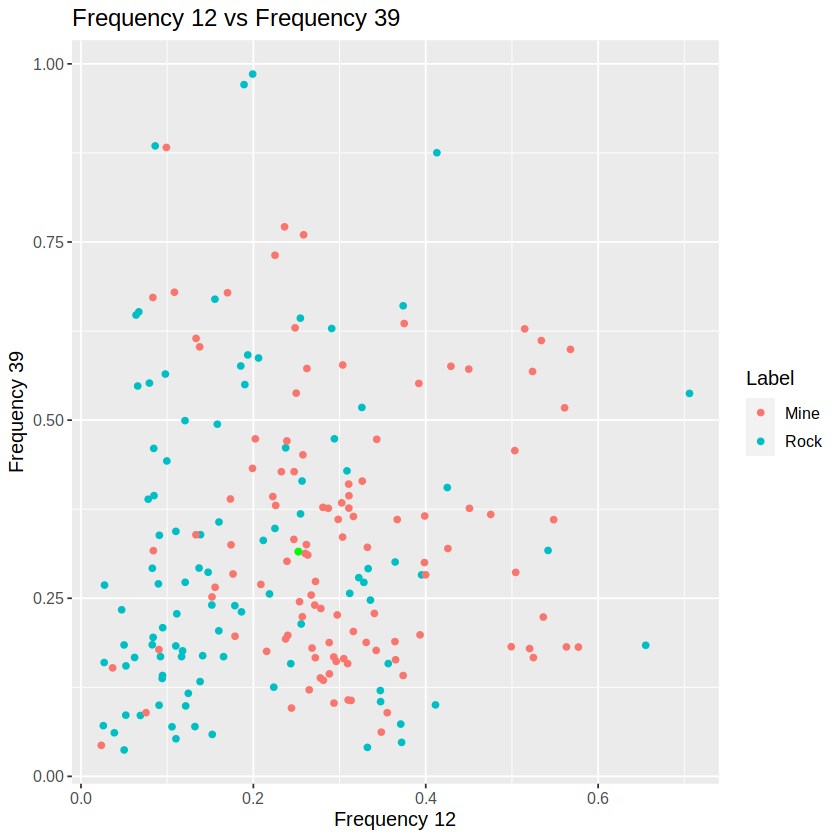

In [88]:
set.seed(5)
new_scatterplot_12_and_39 <- ggplot(new_sonar, aes(x = Freq_12, y = Freq_39, colour = Label)) + 
                       geom_point() +
                       annotate("point", x = 0.252205161, y = 0.315471613, color = "green") +
                       labs(x = "Frequency 12", y = "Frequency 39") +
                       ggtitle("Frequency 12 vs Frequency 39") +
                       theme(text = element_text(size = 12))

new_scatterplot_12_and_39

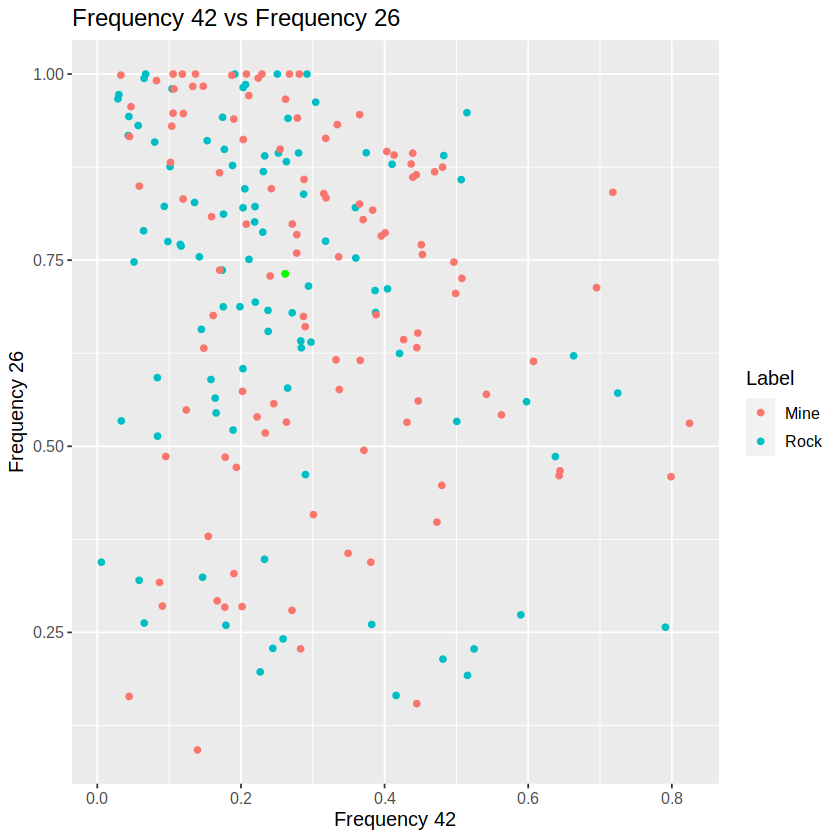

In [89]:
set.seed(5)
new_scatterplot_42_and_26 <- ggplot(new_sonar, aes(x = Freq_42, y = Freq_26, colour = Label)) + 
                       geom_point() +
                       annotate("point", x = 0.261722581, y = 0.731724516, color = "green") +
                       labs(x = "Frequency 42", y = "Frequency 26") +
                       ggtitle("Frequency 42 vs Frequency 26") +
                       theme(text = element_text(size = 12))

new_scatterplot_42_and_26

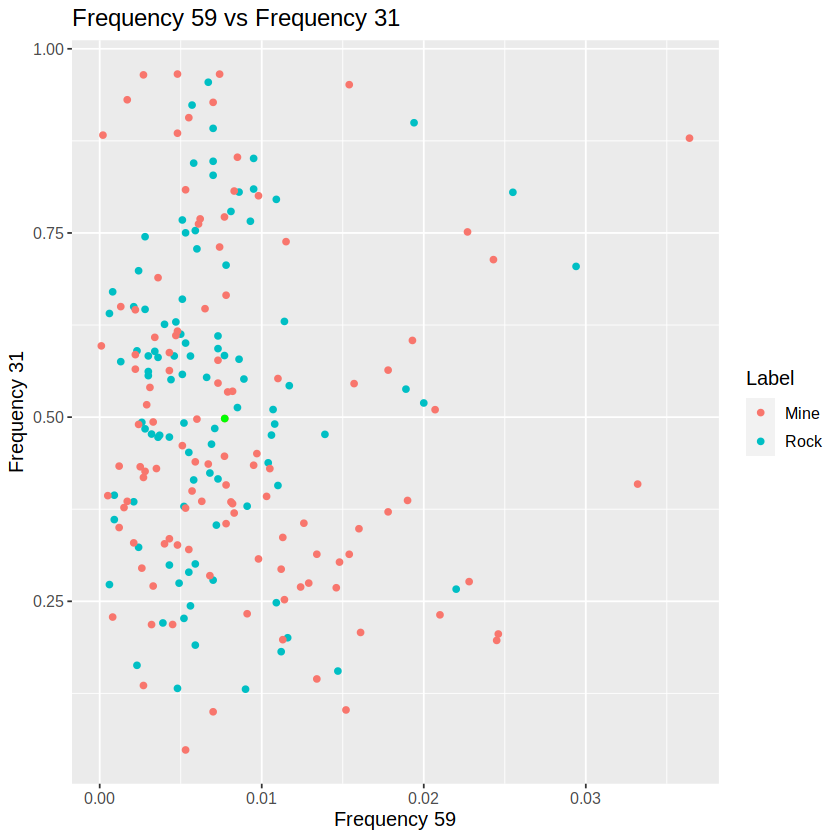

In [94]:
set.seed(5)
new_scatterplot_59_and_31 <- ggplot(new_sonar, aes(x = Freq_59, y = Freq_31, colour = Label)) + 
                       geom_point() +
                       annotate("point", x = 0.007715484, y = 0.498092903, color = "green") +
                       labs(x = "Frequency 59", y = "Frequency 31") +
                       ggtitle("Frequency 59 vs Frequency 31") +
                       theme(text = element_text(size = 12))

new_scatterplot_59_and_31

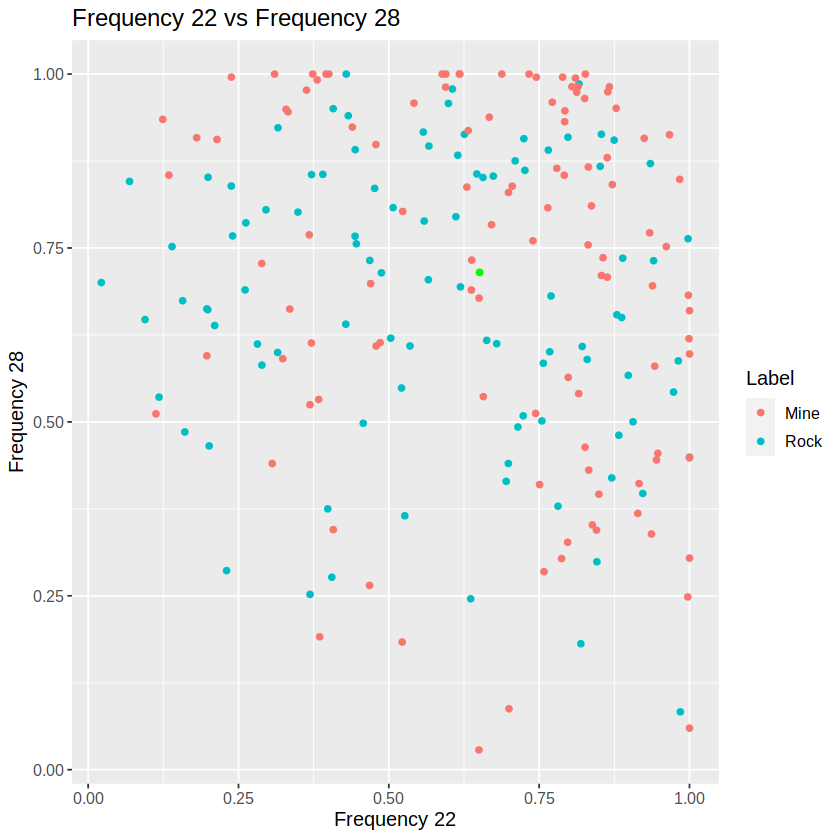

In [93]:
set.seed(5)
new_scatterplot_22_and_28 <- ggplot(new_sonar, aes(x = Freq_22, y = Freq_28, colour = Label)) + 
                       geom_point() +
                       annotate("point", x = 0.650916774, y = 0.714849677, color = "green") +
                       labs(x = "Frequency 22", y = "Frequency 28") +
                       ggtitle("Frequency 22 vs Frequency 28") +
                       theme(text = element_text(size = 12))

new_scatterplot_22_and_28

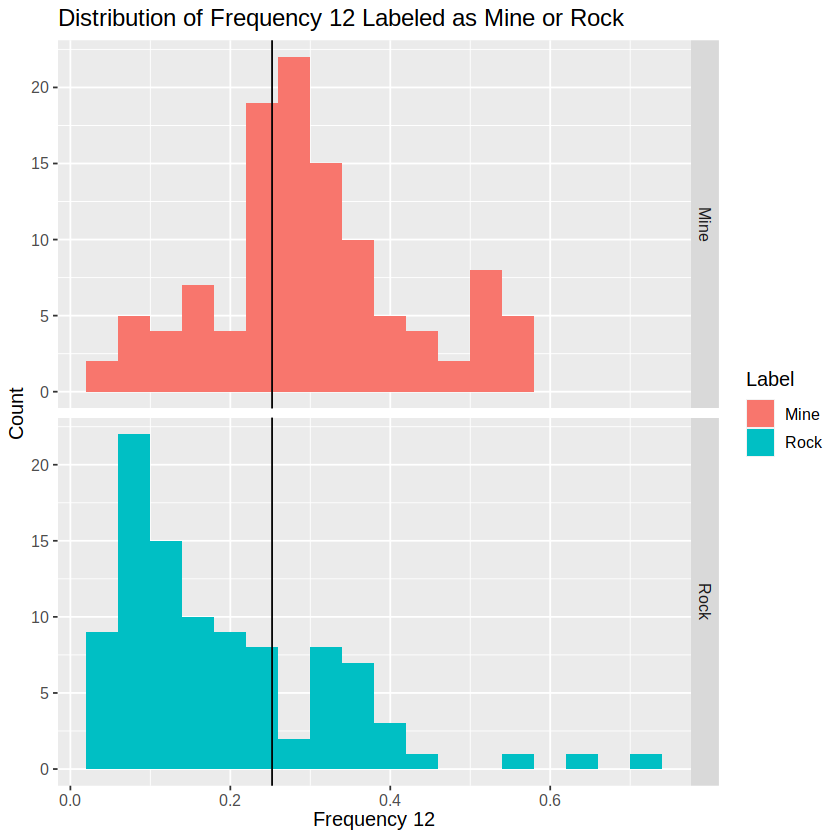

In [85]:
new_hist_12 <- ggplot(new_sonar, aes(x = Freq_12, fill = Label)) + 
          geom_histogram(position = "identity", binwidth = 0.04) + 
          geom_vline(xintercept = 0.252205161) +
          labs(x = "Frequency 12", y = "Count", fill = "Label") +
          ggtitle("Distribution of Frequency 12 Labeled as Mine or Rock") +
          theme(text = element_text(size = 12)) +
          facet_grid(rows = vars(Label))
new_hist_12

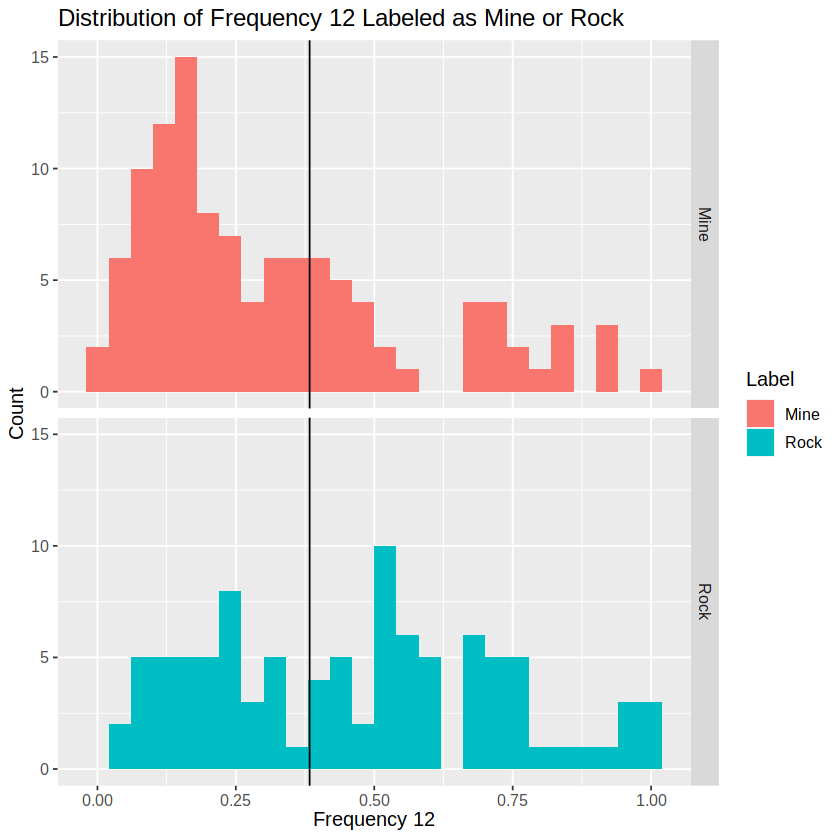

In [100]:
new_hist_21 <- ggplot(new_sonar, aes(x = Freq_36, fill = Label)) + 
          geom_histogram(position = "identity", binwidth = 0.04) + 
          geom_vline(xintercept = 0.383221290) +
          labs(x = "Frequency 12", y = "Count", fill = "Label") +
          ggtitle("Distribution of Frequency 12 Labeled as Mine or Rock") +
          theme(text = element_text(size = 12)) +
          facet_grid(rows = vars(Label))
new_hist_21